In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd

features_filepath = '/content/drive/MyDrive/LakeRegression/340_Veri_toplam_temiz.xlsx'
feats_df = pd.read_excel(features_filepath)
selected_feature = 'Klorofil-a (µg/L)'
feats_df = feats_df[['Date', 'Station', selected_feature, 'X', 'Y']]
feats_df.head()

,Date,Station,Klorofil-a (µg/L),X,Y
0,2017-04-27,1,86.14,235,537
1,2017-04-27,2,61.24,280,427
2,2017-04-27,3,48.40,325,340
3,2017-04-27,4,39.70,345,263
4,2017-04-27,5,72.52,398,165


In [15]:
print('Number of unique dates: ', len(feats_df['Date'].unique()))

feats_df = feats_df[feats_df['Date'] != '12/10/2018'] # cloudy day
feats_df = feats_df[feats_df['Date'] != '12/24/2018'] # cloudy day

print('Number of unique dates: ', len(feats_df['Date'].unique()))

Number of unique dates:  34
Number of unique dates:  32


In [16]:
# (station, x, y)
stations = []
for station in feats_df['Station'].unique():
    stations.append((station, feats_df[feats_df['Station'] == station]['X'].values[0], feats_df[feats_df['Station'] == station]['Y'].values[0]))
stations

[(1, 235, 537),
 (2, 280, 427),
 (3, 325, 340),
 (4, 345, 263),
 (5, 398, 165),
 (6, 342, 107),
 (7, 298, 172),
 (8, 262, 249),
 (9, 225, 337),
 (10, 197, 447)]

In [17]:
import h5py
import numpy as np
import os

def create_patches(image, stations, patch_size):
    _, height, width = image.shape

    patches = []

    for station in stations:
        _, x, y = station

        half_size = patch_size // 2
        start_x = max(0, x - half_size)
        start_y = max(0, y - half_size)
        end_x = min(width, x + half_size + 1)
        end_y = min(height, y + half_size + 1)

        if end_x - start_x < patch_size:
            if start_x - (patch_size - (end_x - start_x)) >= 0:
                start_x -= patch_size - (end_x - start_x)
            else:
                end_x += patch_size - (end_x - start_x)
        if end_y - start_y < patch_size:
            if start_y - (patch_size - (end_y - start_y)) >= 0:
                start_y -= patch_size - (end_y - start_y)
            else:
                end_y += patch_size - (end_y - start_y)

        patch = image[:, start_y:end_y, start_x:end_x]
        patches.append(patch)

    return patches

def create_station_images(patch_size):
    folder_path = '/content/drive/MyDrive/LakeRegression/data'
    file_name = 'level2a.h5'

    for folder in os.listdir(folder_path):
        if folder != '.DS_Store' and folder != '22' and folder != '23':
            current_folder_path = os.path.join(folder_path, folder)
            current_file_path = os.path.join(current_folder_path, file_name)
            with h5py.File(current_file_path, 'r') as f:
                a_group_key = list(f.keys())[0]
                image = np.array(f[a_group_key])
                cropped_images = create_patches(image, stations, patch_size)
                if not cropped_images:
                    print(f"No cropped images created for file {current_file_path}.")
                    continue
                for i, cropped_image in enumerate(cropped_images):
                    if cropped_image.size == 0:
                        print(f"Image at station {i} is empty for file {current_file_path}.")
                        continue
                    cropped_image_path = f'/content/drive/MyDrive/LakeRegression/data/{folder}/station_{i}_{patch_size}.h5'
                    with h5py.File(cropped_image_path, 'w') as hf:
                        hf.create_dataset("station_image",  data=cropped_image)

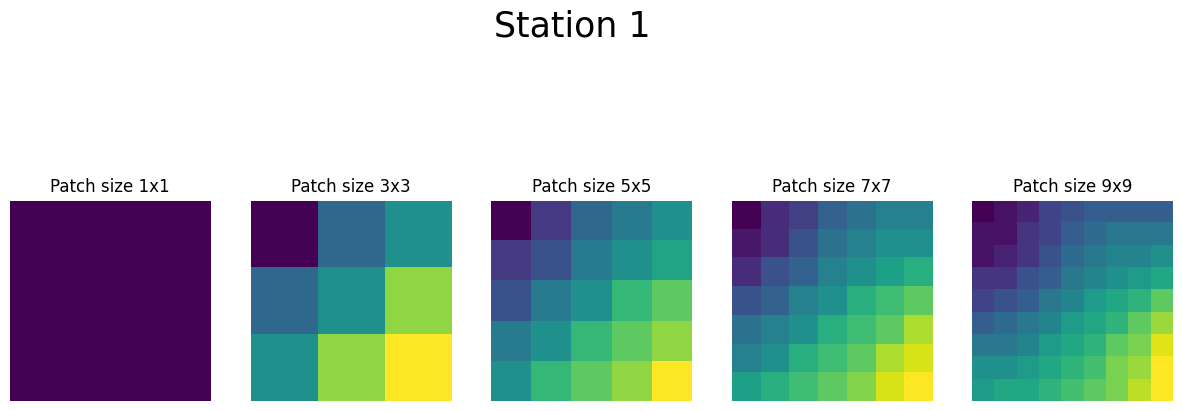

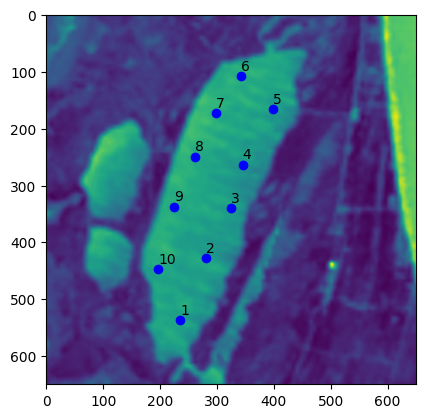

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    create_station_images((i*2+3)-2)
    station_image_path = f'/content/drive/MyDrive/LakeRegression/data/33/station_0_{(i*2+3)-2}.h5'
    with h5py.File(station_image_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        station_image = np.array(f[a_group_key])
        axs[i].imshow(station_image[0])
        axs[i].set_title(f'Patch size {(i*2+3)-2}x{(i*2+3)-2}')
        axs[i].axis('off')
        fig.suptitle('Station 1', fontsize=25)

def plot_stations(stations):
    with h5py.File('/content/drive/MyDrive/LakeRegression/data/33/level2a.h5', 'r') as f:
        a_group_key = list(f.keys())[0]
        image = np.array(f[a_group_key])

    fig, ax = plt.subplots()
    ax.imshow(image[0,:,:])
    for station in stations:
        _, x, y = station
        ax.scatter(x, y, c='blue')
        ax.annotate(station[0], (x, y-10))
    plt.show()

plot_stations(stations)

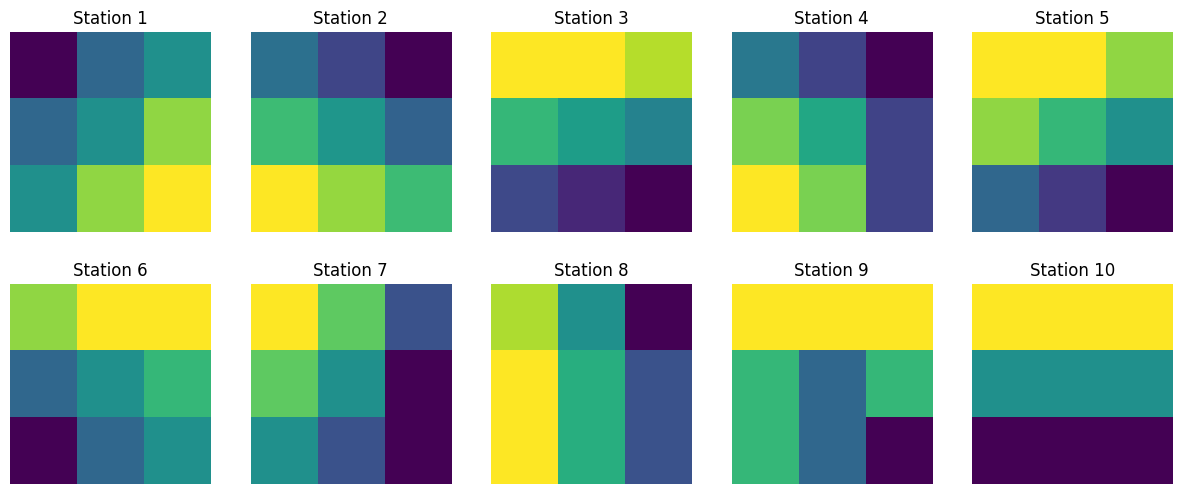

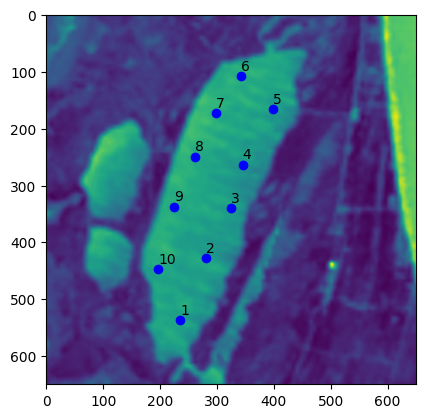

In [19]:
patch_size = 3
create_station_images(patch_size)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        station = i * 5 + j
        station_image_path = f'/content/drive/MyDrive/LakeRegression/data/33/station_{station}_{patch_size}.h5'
        with h5py.File(station_image_path, 'r') as f:
            a_group_key = list(f.keys())[0]
            station_image = np.array(f[a_group_key])
            axs[i, j].imshow(station_image[0])
            axs[i, j].set_title(f'Station {station+1}')
            axs[i, j].axis('off')

plot_stations(stations)